This notebook will try to sort out issues with the waviness in the CF part when there's a loong Cf and a short FM. I'm currently using scipy.signal.sweep_poly to generate flexible frequency modulations. It works by fitting the instantaneous frequency over time to a polynomial and then using that to create the waveform. 

The method mostly works, but fails in the above cases. Essentially, when the frequency sweep suddenly increases its rate - the polynomial fit kind of fails. I need to figure out some hacks/alternatives to this. It'd be sad to throw out such cases just because my simulated calls are bad!!!

-- Thejasvi Beleyur, March 2020

In [9]:
import matplotlib.pyplot as plt 
import numpy as np
import scipy.signal as signal 

from measure_horseshoe_bat_calls.view_horseshoebat_call import *

In [12]:
%matplotlib notebook

In [52]:
## A copy of make_one_CFcall from measure_horseshoe_bat_calls -- which will be heavily modified. 
def make_one_CFcall(call_durn, fm_durn, cf_freq, fs, call_shape, **kwargs):
    '''A test function used to check how well the segmenting+measurement
    functions in the module work. 
    
    Parameters
    ----------
    call_durn : float
    fm_durn : float
    cf_freq : float
    fs : float
    call_shape : str
        One of either 'staplepin' OR 'rightangle'
    fm_bandwidth : float, optional
        FM bandwidth in Hz.


    Returns
    --------
    cfcall : np.array
        The synthesised call. 

    Raises
    -------
    ValueError
        If a call_shape that is not  'staplepin' OR 'rightangle' is given

    Notes
    ------
    This is not really the besssst kind of CF call to test the functions on, 
    but it works okay. The CF call is made by using the poly spline function 
    and this leads to weird jumps in frequency especially around the CF-FM
    junctions. Longish calls with decently long FM parts look fine, but calls
    with very short FM parts lead to rippling of the frequency. 
    '''
    # choose an Fm start/end fr equency :
    FM_bandwidth = np.arange(2,20)
    fm_bw = kwargs.get('fm_bandwidth', np.random.choice(FM_bandwidth, 1)*10.0**3)
    start_f = cf_freq - fm_bw
    # 
    polynomial_num = 25
    t = np.linspace(0, call_durn, int(call_durn*fs))
    # define the transition points in the staplepin
    freqs = np.tile(cf_freq, t.size)
    numfm_samples = int(fs*fm_durn)
    if call_shape == 'staplepin':       
        freqs[:numfm_samples] = np.linspace(start_f,cf_freq,numfm_samples, endpoint=True)
        freqs[-numfm_samples:] = np.linspace(cf_freq,start_f,numfm_samples, endpoint=True)
        p = np.polyfit(t, freqs, polynomial_num)

    elif call_shape == 'rightangle':
        # alternate between rising and falling right angle shapes
        rightangle_type = np.random.choice(['rising','falling'],1)
        if rightangle_type == 'rising':
            freqs[:numfm_samples] = np.linspace(cf_freq,start_f,numfm_samples, endpoint=True)
        elif rightangle_type == 'falling':
            freqs[-numfm_samples:] = np.linspace(cf_freq,start_f,numfm_samples, endpoint=True)
        p = np.polyfit(t, freqs, polynomial_num)

    else: 
        raise ValueError('Wrong input given')
      
    cfcall = signal.sweep_poly(t, p)

    #windowing = np.random.choice(['hann', 'nuttall', 'bartlett','boxcar'], 1)[0]
    windowing= 'boxcar'
    cfcall *= signal.get_window(windowing, cfcall.size)
    cfcall *= signal.tukey(cfcall.size, 0.01)
    return cfcall

C:\Users\tbeleyur\Anaconda2\envs\lim_int\lib\site-packages\ipykernel_launcher.py:3: RankWarning: Polyfit may be poorly conditioned
  This is separate from the ipykernel package so we can avoid doing imports until


<IPython.core.display.Javascript object>


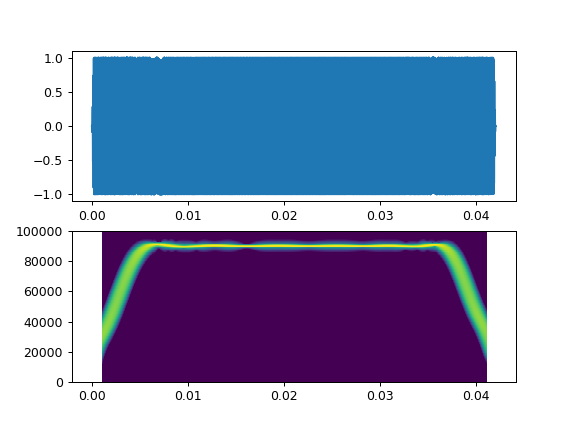

(0, 100000)

In [53]:
fs = 500000
egcall = make_one_CFcall(0.042, 0.001*5, cf_freq=90000.0, fs=fs, call_shape='staplepin',
                               fm_bandwidth=15000*5)
w, s = visualise_call(egcall, fs, fft_size=1024);
s.set_ylim(0,100000)

In [ ]:
fs = 
egcall = make_one_CFcall(0.042*, 0.001, cf_freq=40000.0, fs=fs, call_shape='staplepin',
                               fm_bandwidth=15000)
w, s = visualise_call(egcall, fs, fft_size=512);

In [68]:
freqs = np.concatenate((np.linspace(2000,4000,2), np.tile(4000,15),np.linspace(4000,0,3))).flatten()
times = np.cumsum(np.random.uniform(0.01, 0.02, (20,)))
# or np.arange(20) / sample_freq if evenly sampled
grid, dt = np.linspace(0, times[-1], 10000, retstep=True)
signal = np.sin(2*np.pi*dt*np.cumsum(np.interp(grid, times, freqs))) 

<IPython.core.display.Javascript object>


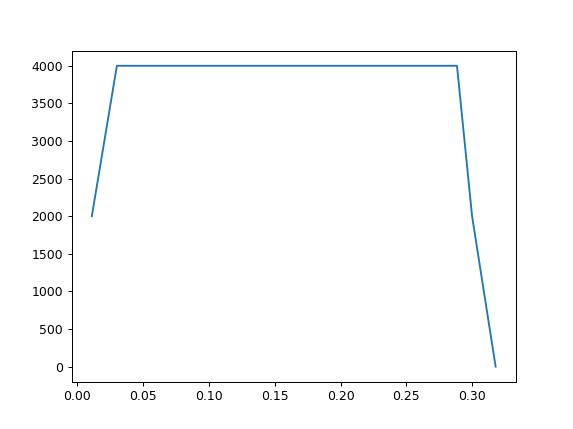

In [69]:
plt.figure()
plt.plot(times, freqs)

<IPython.core.display.Javascript object>


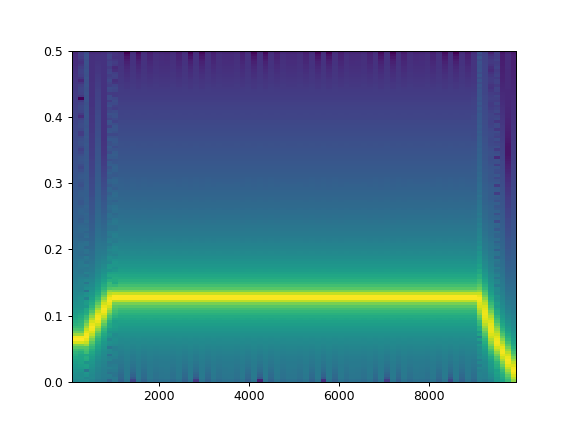

(array([[2.69902486e-07, 3.70707842e-07, 4.59960649e-07, ...,
         1.47907767e-05, 5.92567131e-04, 1.75882426e-01],
        [5.75306433e-07, 6.93627302e-07, 1.65949386e-07, ...,
         3.83148516e-05, 2.21742525e-03, 1.57951023e+00],
        [6.92329223e-07, 6.05742914e-07, 1.23144564e-06, ...,
         7.54346245e-05, 9.34011777e-03, 8.26083469e+00],
        ...,
        [8.83347180e-13, 5.76525781e-12, 9.17114187e-11, ...,
         1.78728383e-13, 8.46064103e-13, 2.25692281e-13],
        [8.31473150e-13, 8.70578822e-12, 9.48445586e-11, ...,
         1.74526091e-13, 8.48228191e-13, 2.21382436e-13],
        [4.07107277e-13, 4.95192120e-12, 3.40314767e-11, ...,
         8.65676466e-14, 4.24474748e-13, 1.09974880e-13]]),
 array([0.        , 0.00390625, 0.0078125 , 0.01171875, 0.015625  ,
        0.01953125, 0.0234375 , 0.02734375, 0.03125   , 0.03515625,
        0.0390625 , 0.04296875, 0.046875  , 0.05078125, 0.0546875 ,
        0.05859375, 0.0625    , 0.06640625, 0.0703125 , 0.074

In [70]:
plt.figure()
plt.specgram(signal,Fs=1)